In [106]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, GRU

import warnings
warnings.simplefilter("ignore")

tf.random.set_seed(455)
np.random.seed(455)


In [107]:
end = datetime.now()
start = datetime(2016, end.month, end.day)
dataset = yf.download("AAPL", start, end)

[*********************100%***********************]  1 of 1 completed


In [108]:
dataset

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-06-14,24.330000,24.620001,24.187500,24.365000,22.497774,127727600
2016-06-15,24.455000,24.602501,24.257500,24.285000,22.423903,117780800
2016-06-16,24.112499,24.437500,24.017500,24.387501,22.518551,125307200
2016-06-17,24.155001,24.162500,23.825001,23.832500,22.006084,244032800
2016-06-20,24.000000,24.142500,23.757500,23.775000,21.952990,137647600
...,...,...,...,...,...,...
2023-06-07,178.440002,181.210007,177.320007,177.820007,177.820007,61944600
2023-06-08,177.899994,180.839996,177.460007,180.570007,180.570007,50214900
2023-06-09,181.500000,182.229996,180.630005,180.960007,180.960007,48870700


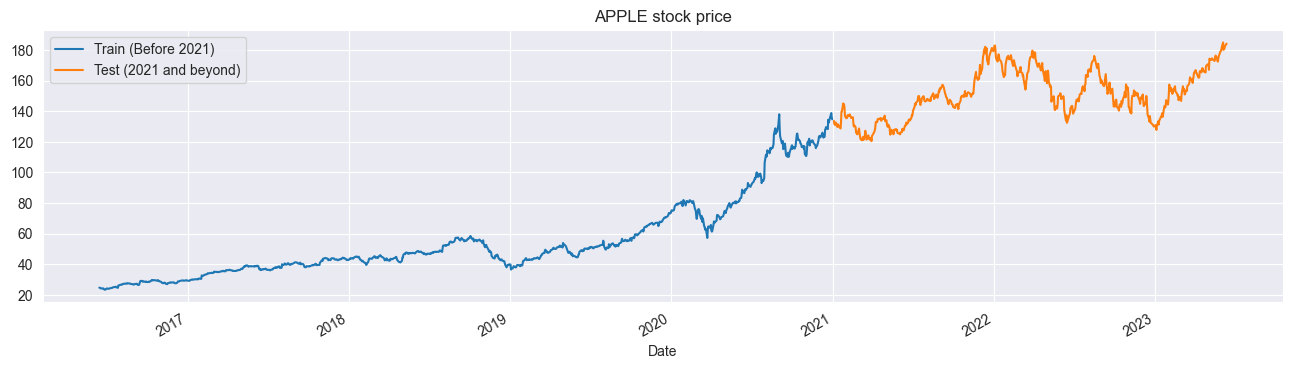

In [109]:
tstart = 2016
tend = 2020

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("APPLE stock price")
    plt.show()

train_test_plot(dataset,tstart,tend)

In [110]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"]
    test = dataset.loc[f"{tend+1}":, "High"]
    return train, test

def train_test_split_values(dataset, tstart, tend):
    train, test =  train_test_split(dataset, tstart, tend)
    return train.values, test.values

training_set, test_set = train_test_split_values(dataset, tstart, tend)

In [111]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [112]:
def split_sequence(sequence, window):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + window
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

window_size = 60
features = 1

X_train, y_train = split_sequence(training_set_scaled, window_size)

In [113]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

In [114]:
dataset_total = dataset.loc[:, "High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - window_size:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

In [115]:
X_test, y_test = split_sequence(inputs, window_size)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
y_test = sc.inverse_transform(y_test)

In [116]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

In [117]:
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(window_size, features)))
model_gru.add(Dense(units=1))

model_gru.compile(optimizer="adam", loss="mse")

model_gru.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 125)               48000     
                                                                 
 dense_6 (Dense)             (None, 1)                 126       
                                                                 
Total params: 48,126
Trainable params: 48,126
Non-trainable params: 0
_________________________________________________________________


2023-06-14 12:49:18.060906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-14 12:49:18.062351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-14 12:49:18.063339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [118]:
model_gru.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10


2023-06-14 12:49:18.327943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-14 12:49:18.329231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-14 12:49:18.330424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

34/34 [==============================] - 3s 21ms/step - loss: 0.0258
Epoch 2/10
34/34 [==============================] - 1s 22ms/step - loss: 6.5973e-04
Epoch 3/10
34/34 [==============================] - 1s 19ms/step - loss: 2.7329e-04
Epoch 4/10
34/34 [==============================] - 1s 19ms/step - loss: 2.7923e-04
Epoch 5/10
34/34 [==============================] - 1s 22ms/step - loss: 2.5004e-04
Epoch 6/10
34/34 [==============================] - 1s 23ms/step - loss: 2.4186e-04
Epoch 7/10
34/34 [==============================] - 1s 23ms/step - loss: 2.4592e-04
Epoch 8/10
34/34 [==============================] - 1s 25ms/step - loss: 2.3787e-04
Epoch 9/10
34/34 [==============================] - 1s 24ms/step - loss: 2.2650e-04
Epoch 10/10
34/34 [==============================] - 1s 23ms/step - loss: 2.2762e-04


In [119]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

 8/20 [===========>..................] - ETA: 0s

2023-06-14 12:49:28.230971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-14 12:49:28.232485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-14 12:49:28.233513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

20/20 [==============================] - 0s 7ms/step


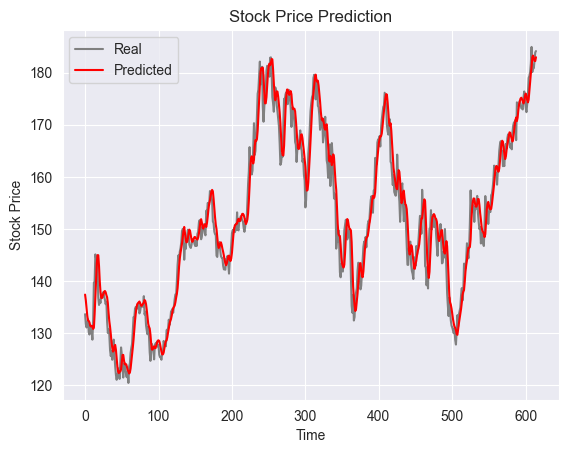

In [120]:
plot_predictions(y_test, GRU_predicted_stock_price)

In [121]:
return_rmse(y_test,GRU_predicted_stock_price)

The root mean squared error is 3.37.
